# Utilities and imports

In [1]:
from maxentnuc.analysis.domain_analyzer import DomainAnalyzer, get_boundary_loops, Domains
from maxentnuc.analysis.mei_analyzer import MEIAnalyzer
from maxentnuc.analysis.analysis import *
from maxentnuc.analysis.insulation import *

from matplotlib.colors import LogNorm
import os
from cooltools.api.insulation import _insul_diamond_dense
from neighbor_balance.plotting import parse_region, format_ticks, ContactMap, apply_matplotlib_style, load_bw, bin_track

omics = '/home/joepaggi/orcd/pool/omics'
mei_runs = '/orcd/data/binz/001/joepaggi/mei_runs'

apply_matplotlib_style()

In [3]:
for conc in [150, 200, 300]:
    for radius in [20, 25, 30, 40]:
        analyzer = DomainAnalyzer(radius, conc, min_loop_size=2, add_boundary_linkers=True)
        print(conc, radius, analyzer.min_samples, to_micromolar(analyzer.min_samples, 4/3*np.pi*radius**3))

150 20 3 148.66266271868338
150 25 6 152.2305666239318
150 30 10 146.82732120363792
150 40 24 148.66266271868338
200 20 4 198.2168836249112
200 25 8 202.97408883190906
200 30 14 205.5582496850931
200 40 32 198.2168836249112
300 20 6 297.32532543736676
300 25 12 304.4611332478636
300 30 20 293.65464240727584
300 40 48 297.32532543736676


In [10]:
import pickle

def compute_domains(prod):
    domains = {}
    for name, info in prod.items():
        trajectory = info['mei'].get_positions(info['iteration'], skip=11, burnin=0)
        trajectory = trajectory.reshape(-1, *trajectory.shape[-2:])

        for conc in [150, 200, 300]:
            for radius in [25, 30, 40]:
                analyzer = DomainAnalyzer(radius, conc, min_loop_size=2, add_boundary_linkers=True)
                print(conc, radius, analyzer.min_samples, to_micromolar(analyzer.min_samples, 4/3*np.pi*radius**3))
                domains[(name, conc, radius)] = analyzer.analyze_trajectory(trajectory)
    return domains

def load_or_compute_domains(prod, cache_file):
    if os.path.exists(cache_file):
        print("Loading cached domains...")
        with open(cache_file, 'rb') as f:
            data = pickle.load(f)
            domains = data['domains']
            _prod = data['prod']

            for k in prod:
                assert prod[k]['config'] == _prod[k]['config']
                assert prod[k]['iteration'] == _prod[k]['iteration']
    else:
        print("Computing domains...")
        domains = compute_domains(prod)
        with open(cache_file, 'wb') as f:
            data = {
                'domains': domains,
                'prod': prod,
            }
            pickle.dump(data, f)
    return domains

prod = {
    'klf1': {'config': f'{mei_runs}/klf1/v3/config.yaml', 'iteration': 11},
    'fbn2' : {'config': f'{mei_runs}/fbn2/v2/config.yaml', 'iteration': 12},
}

for name in prod:
    prod[name]['mei'] = MEIAnalyzer(prod[name]['config'], scale=0.1)

cache_file = 'domains_dbscan.pkl'
domains = load_or_compute_domains(prod, cache_file)

Loading cached domains...


In [11]:
colors = {
    ('klf1', 200, 30): 'k',
    ('klf1', 150, 30): plt.get_cmap('tab20')(0),
    ('klf1', 300, 30): plt.get_cmap('tab20')(2),
    ('klf1', 200, 25): plt.get_cmap('tab20')(4),
    ('klf1', 200, 40): plt.get_cmap('tab20')(6),

    ('fbn2', 200, 30): 'gray',
    ('fbn2', 150, 30): plt.get_cmap('tab20')(1),
    ('fbn2', 300, 30): plt.get_cmap('tab20')(3),
    ('fbn2', 200, 25): plt.get_cmap('tab20')(5),
    ('fbn2', 200, 40): plt.get_cmap('tab20')(7),
}

('klf1', 150, 30) 0.04067796610169491
('klf1', 200, 30) 0.12562313060817548
('klf1', 300, 30) 0.3300099700897308
('klf1', 200, 25) 0.0843469591226321
('klf1', 200, 30) 0.12562313060817548
('klf1', 200, 40) 0.15912263210368893


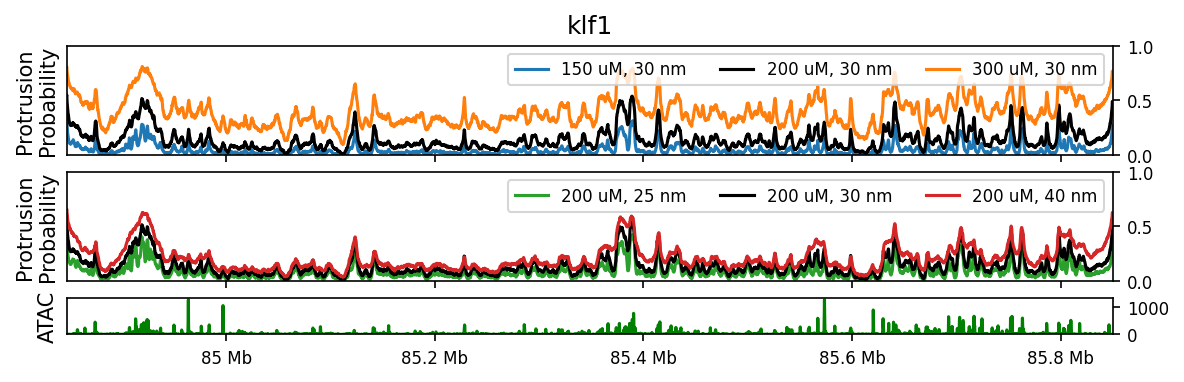

('fbn2', 150, 30) 0.014460285132382893
('fbn2', 200, 30) 0.04541751527494908
('fbn2', 300, 30) 0.1920570264765784
('fbn2', 200, 25) 0.029531568228105907
('fbn2', 200, 30) 0.04541751527494908
('fbn2', 200, 40) 0.0635437881873727


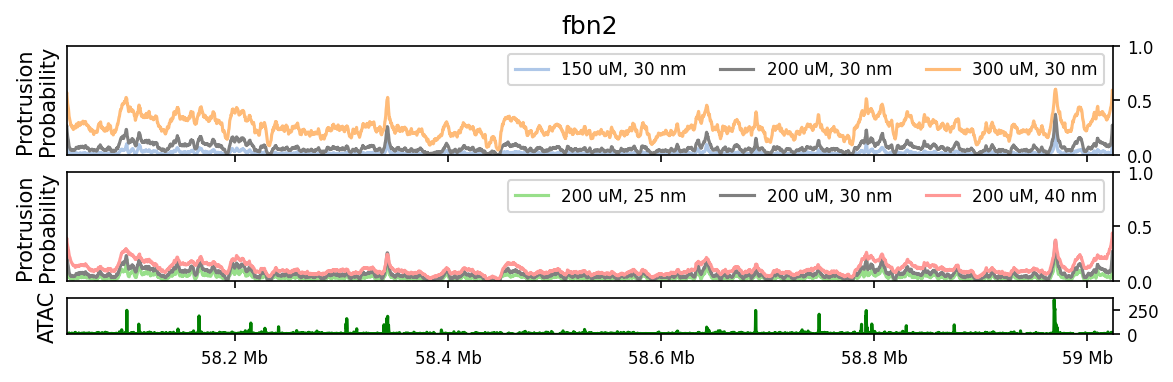

In [40]:
def get_loops(labels):
    loops = []
    loop_start = None
    for i in range(len(labels)):
        if labels[i] == -1:
            if loop_start is None:
                loop_start = i
        elif loop_start is not None:
            loops += [(loop_start, i)]
            loop_start = None
    if loop_start is not None:
        loops += [(loop_start, len(labels))]
    return loops

def get_boundary_loops(labels):
    loops = get_loops(labels)
    print(loops)

    boundary_loops = []
    for start, end in loops:
        if start == 0:
            continue
        if end == len(labels) - 1:
            continue

        if labels[start - 1] != labels[end]:
            boundary_loops += [(start, end)]

    mask = labels[1:] != labels[:-1]
    mask &= labels[1:] != -1
    mask &= labels[:-1] != -1
    no_loops = np.arange(len(mask))[mask]
    for s in no_loops:
        boundary_loops += [(s, s+1)]
    return boundary_loops


for region_name in prod:
    region = prod[region_name]['mei'].mei.config['region']
    chrom, start, end = parse_region(region)

    f, ax = plt.subplots(3, figsize=(9, 2.5), sharex=True, gridspec_kw={'height_ratios': [3, 3, 1]})
    x = np.arange(start, end, 200)
    atac = f'{omics}/genomics_data/GSE98390_E14_ATAC_MERGED.DANPOS.mm39.bw'
    atac = load_bw(atac, chrom, start, end)
    atac = bin_track(atac, step=200)
    ax[2].plot(x, atac, c='green')

    buff = 50_000 // 200
    metrics = {}
    loops = {}
    for params_name in [(150, 30), (200, 30), (300, 30)]:
        name = (region_name, *params_name)
        label = f'{params_name[0]} uM, {params_name[1]} nm'
        print(name, np.mean(domains[name][0].labels == -1))
        loop = np.array([d.labels == -1 for d in domains[name]]).astype(bool)
        ax[0].plot(x, np.mean(loop, axis=0), label=label, color=colors[name])
        metrics[name] = {}
        metrics[name]['loop'] = np.mean(loop[:, buff:-buff], axis=1)


    for params_name in [(200, 25), (200, 30), (200, 40)]:
        name = (region_name, *params_name)
        label = f'{params_name[0]} uM, {params_name[1]} nm'
        print(name, np.mean(domains[name][0].labels == -1))
        loop = np.array([d.labels == -1 for d in domains[name]]).astype(bool)

        ax[1].plot(x, np.mean(loop, axis=0), label=label, color=colors[name])

        metrics[name] = {}
        metrics[name]['loop'] = np.mean(loop[:, buff:-buff], axis=1)

    for i in range(2):
        ax[i].legend(loc='upper right', ncols=3, fontsize=8)
        ax[i].set_ylabel('Protrusion\nProbability')
        ax[i].yaxis.tick_right()
        ax[i].set_ylim(0, 1)

    ax[2].set_ylabel('ATAC')
    ax[2].yaxis.tick_right()
    ax[2].set_ylim(0)
    ax[2].set_xlim(start, end)
    format_ticks(ax[2], y=False, rotate=False)
    ax[0].set_title(region_name)
    plt.savefig(f'img/dbscan_params_protrusion_{region_name}.pdf')
    plt.show()

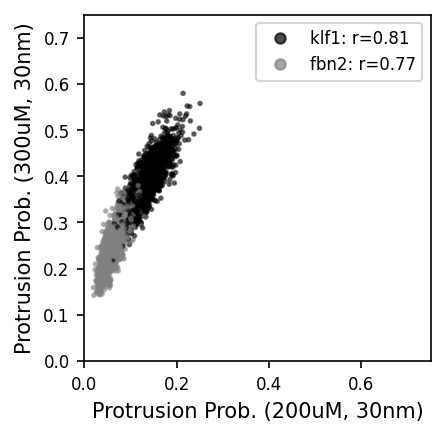

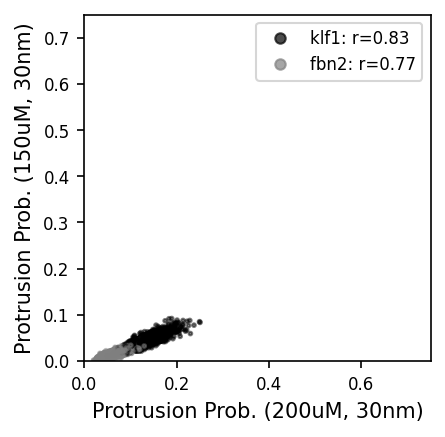

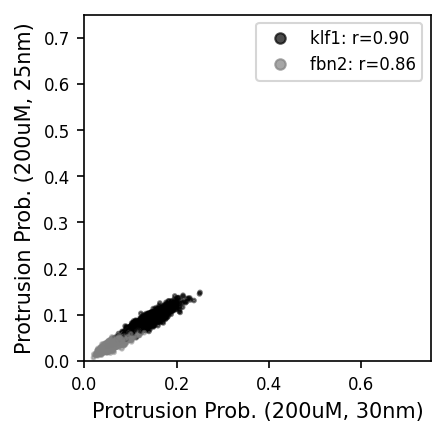

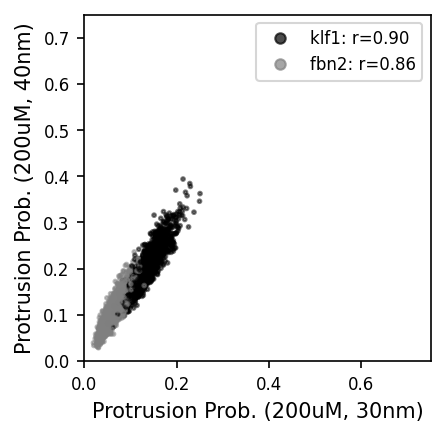

In [31]:
from scipy.stats import spearmanr
from matplotlib.lines import Line2D

def get_p_loop(region_name, conc, radius):
    name = (region_name, conc, radius)
    loop = np.array([d.labels == -1 for d in domains[name]]).astype(bool)
    p_loop = np.mean(loop[:, 50_000//200:-50_000//200], axis=1)
    return p_loop

for conc, radius in [(300, 30), (150, 30), (200, 25), (200, 40)]:
    f, ax = plt.subplots(figsize=(3,3))
    x, y, c = [], [], []
    handles = []
    labels = []
    for region_name in ['klf1', 'fbn2']:
        ref_p_loop = get_p_loop(region_name, 200, 30)
        p_loop = get_p_loop(region_name, conc, radius)
        r, p = spearmanr(ref_p_loop, p_loop)
        color = colors[(region_name, 200, 30)]

        handle = Line2D(
            [], [],
            marker='o',
            linestyle='none',
            markersize=5,
            color=color,
            alpha=0.7
        )
        handles.append(handle)
        labels.append(f'{region_name}: r={r:.2f}')

        x += [ref_p_loop]
        y += [p_loop]
        c += [np.full_like(ref_p_loop, color, dtype=object)]
    x = np.concatenate(x)
    y = np.concatenate(y)
    c = np.concatenate(c)
    
    np.random.seed(0)
    perm = np.random.permutation(len(x))
    ax.scatter(x[perm], y[perm], rasterized=True, s=3, alpha=0.5, c=c[perm])
    ax.set_aspect('equal')
    ax.set_ylim(0, 0.75)
    ax.set_xlim(0, 0.75)
    ax.set_xlabel('Protrusion Prob. (200uM, 30nm)')
    ax.set_ylabel(f'Protrusion Prob. ({conc}uM, {radius}nm)')
    ax.legend(handles, labels)
    plt.savefig(f'img/dbscan_params_correlations_{conc}_{radius}.pdf')
    plt.show()

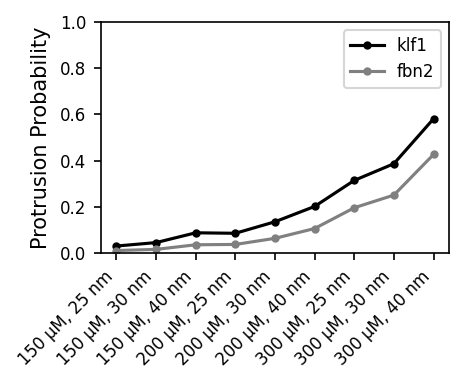

In [52]:
f, ax = plt.subplots(figsize=(3, 2))

for region_name in ['klf1', 'fbn2']:
    y = []
    x = []
    for conc in [150, 200, 300]:
        for radius in [25, 30, 40]:
            name = (region_name, conc, radius)
            loop = np.array([d.labels == -1 for d in domains[name]]).astype(bool)
            p_loop = np.mean(loop[:, 50_000//200:-50_000//200])
            y += [p_loop]
            x += [(conc, radius)]
    plt.plot(y, c=colors[(region_name, 200, 30)], label=region_name, marker='o', markersize=3)
plt.ylim(0, 1)
plt.xticks(range(len(x)), [f'{c} µM, {r} nm' for c, r in x], rotation=45, ha='right')
plt.legend()
plt.ylabel('Protrusion Probability')
#plt.xlabel('DBSCAN Parameters')
plt.savefig('img/dbscan_params_protrusion_summary.pdf')
plt.show()

Plotting region: klf1


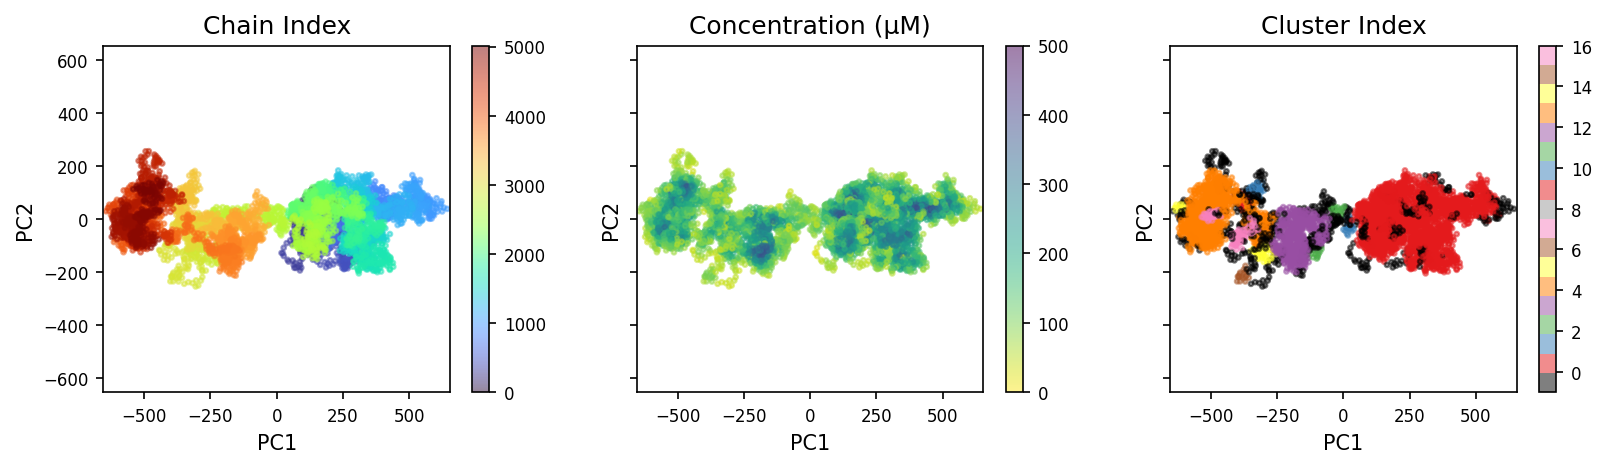

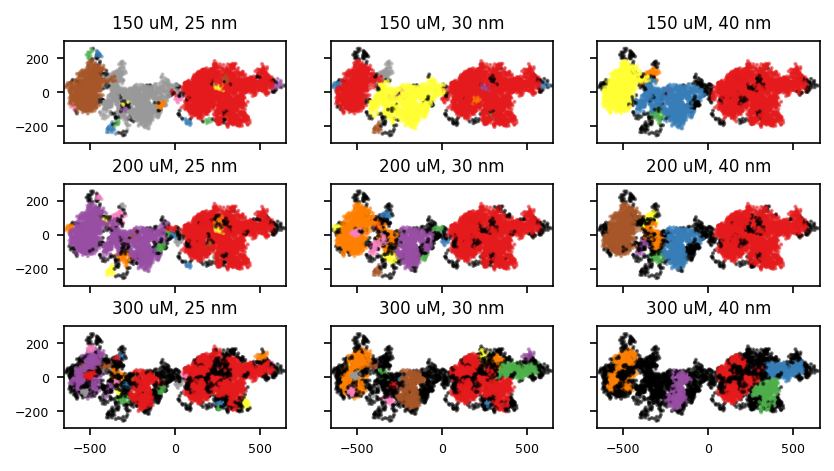

Plotting region: fbn2


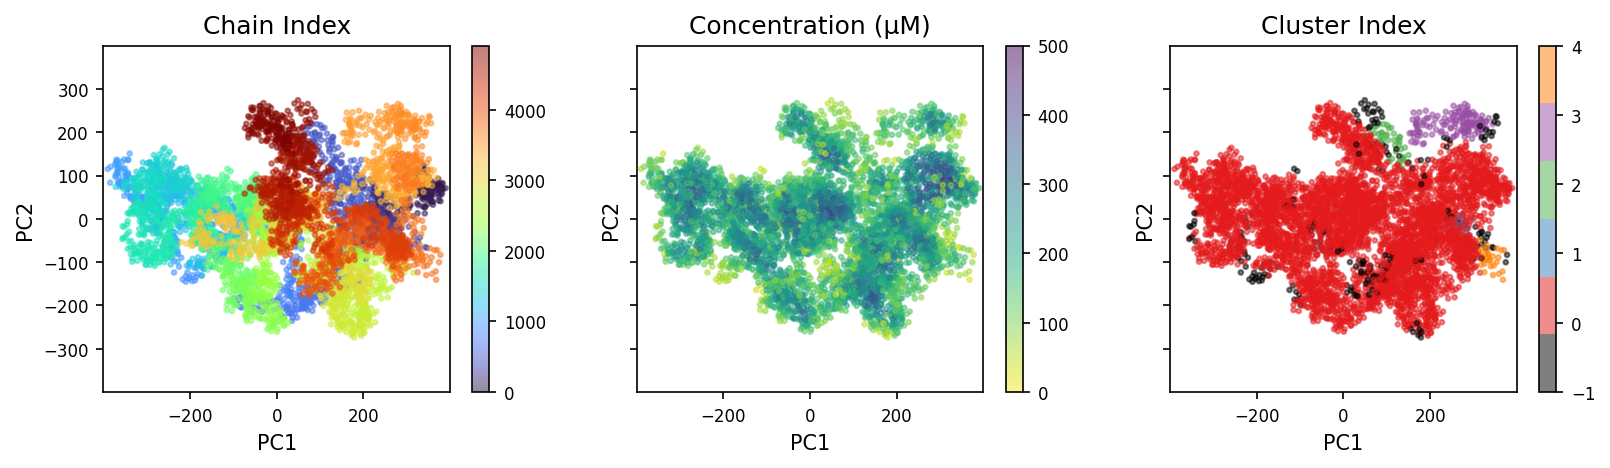

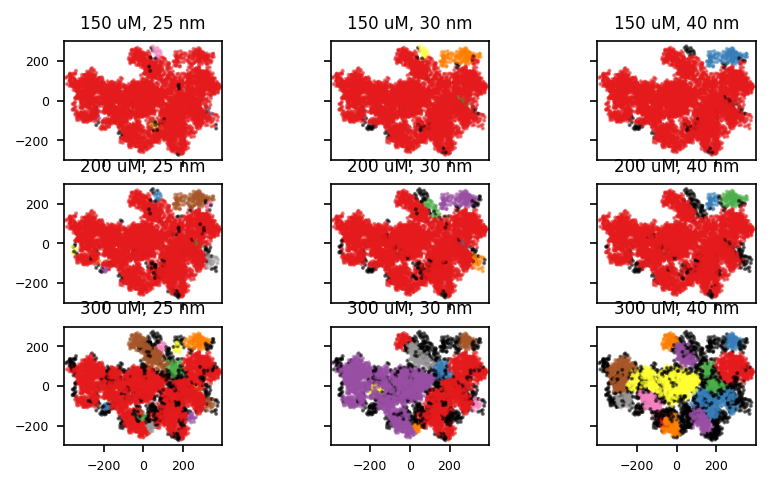

In [48]:
for region_name in prod:
    print(f'Plotting region: {region_name}')
    example = domains[(region_name, 200, 30)][0]
    example.plot_all_2D()
    plt.show()
    f, axs = plt.subplots(3, 3, figsize=(6.5, 3.5), sharex=True, sharey=True)
    axs_flat = axs.flatten()

    keys = [key for key in domains.keys() if key[0] == region_name]

    for i, name in enumerate(keys):
        example = domains[name][0]
        example.plot_2D(ax=axs_flat[i], colorbar=False, s=1)
        axs_flat[i].set_title(f'{name[1]} uM, {name[2]} nm', size=8)

    for i in range(3):
        for j in range(3):
            axs[i, j].set_ylim(-300, 300)
            axs[j, i].set_xlabel('')
            axs[j, i].set_ylabel('')
            axs[j, i].tick_params(axis='y', labelsize=6)
            axs[j, i].tick_params(axis='x', labelsize=6)
    plt.savefig(f'img/dbscan_params_grid_{region_name}.pdf')
    
    plt.show()

In [8]:
from scipy.stats import gaussian_kde

def myhist(data, bins, ax=None, density=True, bw = 0.05, alpha=1, lw=1, n_points=1000, weights=None, **kwargs):
    p = plt if ax is None else ax
    if data.min() < bins[0] or data.max() > bins[-1]:
        print(f'Warning: data outside range ({data.min()} to {data.max()} vs {bins[0]} to {bins[-1]})')
    
    cov = np.cov(np.log10(data), aweights=weights if weights is not None else None)
    kde = gaussian_kde(np.log10(data), weights=weights, bw_method=bw / cov**0.5)

    x = np.arange(1, 500) * 200 # plot every 200 bp from 200 to 100 kb
    x = np.concatenate([x, np.logspace(np.log10(x[-1]), np.log10(bins[-1]), n_points)])
    y = kde(np.log10(x))
    p.plot(x, y, lw=lw, alpha=alpha, **kwargs)


def plot_size_distributions(domains, colors=None, labels=None, axs=None):
    bins = np.logspace(np.log10(199), np.log10(2_000_000), 21)
    if axs is None:
        f, axs = plt.subplots(1, 3, sharex=True, figsize=(6.5, 1))
    for name, domain in domains.items():
        if colors is not None:
            color = colors[name]
        else:
            color = None

        if labels is not None:
            label = labels[name]
        else:
            label = name

        # Linkers.
        linkers = [Domains(d.positions.copy(), get_segments(d.labels == -1)) for d in domain]
        w = np.array([np.sum(_domain.labels==i) for _domain in linkers for i in range(_domain.n_clusters)])
        w *= 200
        myhist(w, bins=bins, label=label, ax=axs[0], weights=np.zeros(w.shape) + 1 / len(w), density=False, color=color)

        # Domains
        w = np.array([np.sum(_domain.labels==i) for _domain in domain for i in range(_domain.n_clusters)])
        w *= 200
        print(np.median(w))
        myhist(w, bins=bins, label=label, ax=axs[1], weights=np.zeros(w.shape) + 1 / len(w), density=False, color=color)
        myhist(w, bins=bins, label=label, ax=axs[2], weights=w/sum(w), density=False, color=color)

    axs[0].set_title('Protrusion sizes', fontsize=8)
    axs[1].set_title('Domain sizes', fontsize=8)
    axs[2].set_title('Domain sizes weighted by size', fontsize=8)
    axs[0].set_ylabel('Frequency (A.U.)', fontsize=8)
    axs[1].set_xscale('log')

    for ax in axs:
        ax.set_yticks([])
        ax.set_ylim(0)
        format_ticks(ax, y=False)
    return axs

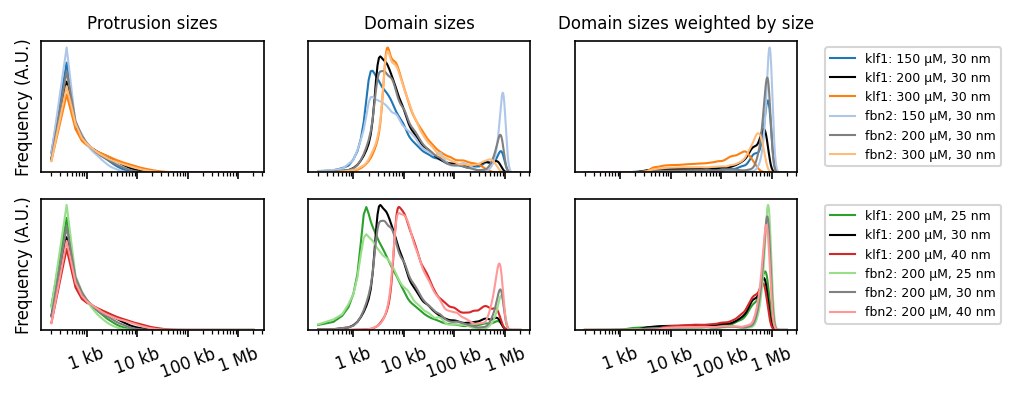

In [ ]:


f, axs = plt.subplots(2, 3, sharex=True, figsize=(6.5, 2.5))

labels = {k: f'{k[0]}: {k[1]} µM, {k[2]} nm' for k in domains.keys()}

_domains = {k: v for k, v in domains.items() if k[2] == 30}
plot_size_distributions(_domains, colors=colors, labels=labels, axs=axs[0])
axs[0, 2].legend(fontsize=6, loc='center left', bbox_to_anchor=(1.1, 0.5), ncols=1)

_domains = {k: v for k, v in domains.items() if k[1] == 200}
plot_size_distributions(_domains, colors=colors, labels=labels, axs=axs[1])
axs[1, 2].legend(fontsize=6, loc='center left', bbox_to_anchor=(1.1, 0.5), ncols=1)

for a in axs[1]:
    a.set_title('')

plt.savefig('img/dbscan_params_domain_sizes.pdf')
plt.show()

In [4]:
prod = {
    'klf1': {'config': f'{mei_runs}/klf1/v3/config.yaml', 'iteration': 11},
    'fbn2' : {'config': f'{mei_runs}/fbn2/v2/config.yaml', 'iteration': 12},
}

for name in prod:
    prod[name]['mei'] = MEIAnalyzer(prod[name]['config'], scale=0.1)

domains = {}
for name, info in prod.items():
    trajectory = info['mei'].get_positions(info['iteration'], skip=110, burnin=0)
    trajectory = trajectory.reshape(-1, *trajectory.shape[-2:])

    for conc in [150]:
        for radius in [20]:
            analyzer = DomainAnalyzer(radius, conc, min_loop_size=2, add_boundary_linkers=True)
            print(conc, radius, analyzer.min_samples, to_micromolar(analyzer.min_samples, 4/3*np.pi*radius**3))
            domains[(name, conc, radius)] = analyzer.analyze_trajectory(trajectory)

/orcd/data/binz/001/joepaggi/mei_runs/klf1/v3/011_trajectory.*.dcd


/home/joepaggi/miniconda3/envs/neighbor/lib/python3.12/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"
INFO:MDAnalysis.core.universe:The attribute(s) types, masses have already been read from the topology file. The guesser will only guess empty values for this attribute, if any exists. To overwrite it by completely guessed values, you can pass the attribute to the force_guess parameter instead of the to_guess one
INFO:MDAnalysis.guesser.base:There is no empty types values. Guesser did not guess any new values for types attribute
INFO:MDAnalysis.guesser.base:There is no empty masses values. Guesser did not

150 20 3 148.66266271868338


/orcd/data/binz/001/joepaggi/mei_runs/fbn2/v2/012_trajectory.*.dcd


/home/joepaggi/miniconda3/envs/neighbor/lib/python3.12/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"
INFO:MDAnalysis.core.universe:The attribute(s) types, masses have already been read from the topology file. The guesser will only guess empty values for this attribute, if any exists. To overwrite it by completely guessed values, you can pass the attribute to the force_guess parameter instead of the to_guess one
INFO:MDAnalysis.guesser.base:There is no empty types values. Guesser did not guess any new values for types attribute
INFO:MDAnalysis.guesser.base:There is no empty masses values. Guesser did not

150 20 3 148.66266271868338


/tmp/ipykernel_1930811/578785469.py:14: MatplotlibDeprecationWarning: Passing label as a length 3 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  p.plot(x, y, lw=lw, alpha=alpha, **kwargs)


1000.0
1200.0


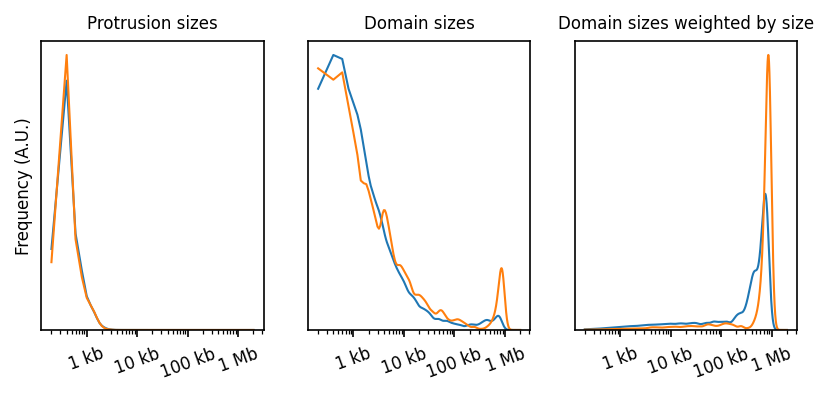

In [9]:
f, axs = plt.subplots(1, 3, sharex=True, figsize=(6.5, 2.5))
plot_size_distributions(domains, axs=axs)
plt.show()